In [2]:
# Install FiftyOne
!pip install fiftyone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import fiftyone as fo
import fiftyone.zoo as foz

import cv2
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import skimage.io as io

import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split

import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from pycocotools.coco import COCO
import torchvision.transforms as T

import torchvision.transforms as transforms

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Download the COCO dataset
# dataset = foz.load_zoo_dataset(
#     "coco-2017",
#     split="validation",
#     dataset_dir="/content/drive/MyDrive/COCO_dataset/validation",
#     label_types=["detections"]
#     )

# # Download the COCO training dataset
# dataset = foz.load_zoo_dataset(
#     "coco-2017",
#     split="train",
#     dataset_dir="/content/drive/MyDrive/COCO_dataset/train",
#     label_types=["detections"],
#     # classes=["person"]
#     max_samples=25000,
# )

### Load and visualize Oxford Town

In [7]:
oxford_annotations = pd.read_csv('/content/drive/MyDrive/Oxford/TownCentre-groundtruth.top', names= ['personNumber', 'frameNumber',
                                'headNumber', 'bodyNumber', 'headLeft', 'headTop', 'headRight', 'headBottom', 'bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom'])
oxford_annotations.head(5)

,personNumber,frameNumber,headNumber,bodyNumber,headLeft,headTop,headRight,headBottom,bodyLeft,bodyTop,bodyRight,bodyBottom
0,0,0,1,1,270.828,794.098,309.037,834.066,235.925,770.142,371.546,1101.029
1,1,0,1,1,308.304,302.982,330.837,326.823,285.748,291.418,370.556,493.414
2,2,0,1,1,307.919,241.003,328.645,262.841,286.849,230.501,365.794,416.410
3,3,0,1,1,739.951,231.693,759.968,253.491,719.708,220.830,786.893,408.145
4,4,0,1,1,814.375,246.562,835.021,268.946,793.722,235.410,861.430,427.627


In [8]:
oxford_video_path = '/content/drive/MyDrive/Oxford/TownCentreXVID.mp4'
output_dir = '/content/drive/MyDrive/Oxford/Images'

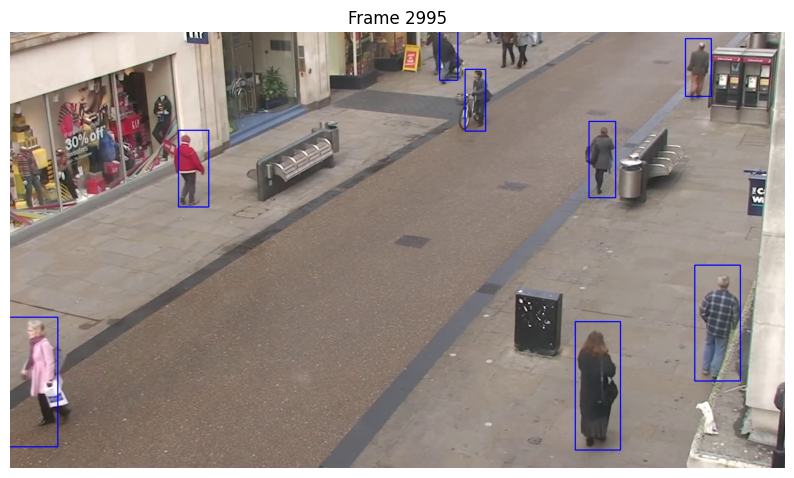

In [9]:
# Function to draw bounding boxes on an image
def draw_bounding_boxes(image, boxes):
    for box in boxes:
        x1 = int(box[0])
        y1 = int(box[1])
        x2 = int(box[2])
        y2 = int(box[3])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue color bounding box
    return image

# Visualize images with bounding boxes
frames = oxford_annotations['frameNumber'].unique()
frames10 = frames[2995:2996]
for frame in frames10:
    frame = int(frame)
    image_path = os.path.join(output_dir, f'{frame}.jpg')
    image = cv2.imread(image_path)

    if image is not None:
        # Extract bounding box coordinates for the current frame
        boxes = oxford_annotations[oxford_annotations['frameNumber'] == frame][['bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom']].values

        # Draw bounding boxes on the image
        image_with_boxes = draw_bounding_boxes(image, boxes)

        # Convert BGR image to RGB for matplotlib
        image_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

        # Display the image with bounding boxes
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.title(f'Frame {frame}')
        plt.axis('off')
        plt.show()
    else:
        print(f"Image for frame {frame} not found.")

loading annotations into memory...
Done (t=25.18s)
creating index...
index created!


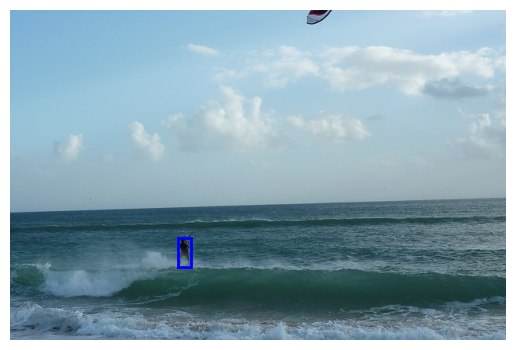

In [10]:
# Paths to annotation files
coco_train_inst_ann_file = "/content/drive/MyDrive/COCO_dataset/train/raw/instances_train2017.json"

# Visualize example image
coco = COCO(coco_train_inst_ann_file)
catIds = coco.getCatIds(catNms='person')
imgIds = coco.getImgIds(catIds=catIds)

# Filter images with at least one bounding box annotation
filtered_imgIds = []
for img_id in imgIds:
    annIds = coco.getAnnIds(imgIds=img_id, iscrowd=None)
    anns = coco.loadAnns(annIds)
    if any(ann['bbox'] for ann in anns):
        filtered_imgIds.append(img_id)

# Initialize random image
random_img_id = random.choice(filtered_imgIds)

# Initialize random image
img = coco.loadImgs(random_img_id)[0]

# Load the image
I = io.imread(img['coco_url'])

fig, ax = plt.subplots()
ax.imshow(I)

annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None, catIds=catIds[0])
anns = coco.loadAnns(annIds)

for ann in anns:
    box = ann['bbox']
    bb = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor="blue", facecolor="none")
    ax.add_patch(bb)

plt.axis('off')
plt.show()

In [11]:
def filter_image_ids(img_dir, coco, coco_caps, words):
    # List downloaded images
    downloaded_imgs = set(os.listdir(img_dir))

    # Get image IDs for images containing people
    cat_ids = coco.getCatIds(catNms=['person'])
    img_ids = coco.getImgIds(catIds=cat_ids)

    filtered_img_ids = []
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_filename = img_info['file_name']
        if img_filename in downloaded_imgs:
            ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=None)
            anns = coco.loadAnns(ann_ids)
            if any(ann['bbox'] for ann in anns):
                cap_ids = coco_caps.getAnnIds(imgIds=img_id)
                caps = coco_caps.loadAnns(cap_ids)
                for cap in caps:
                    caption = cap['caption'].lower()
                    if any(word in caption for word in words):
                        filtered_img_ids.append(img_id)
                        break

    print(f"Found {len(filtered_img_ids)} images matching criteria.")
    return filtered_img_ids

In [12]:
def resize_with_padding(image, target_size):
    # Resize while maintaining aspect ratio
    image.thumbnail((target_size, target_size), Image.LANCZOS)
    # Create a new image with the target size and paste the resized image
    new_image = Image.new("RGB", (target_size, target_size), (0, 0, 0))
    new_image.paste(image, ((target_size - image.width) // 2, (target_size - image.height) // 2))
    return new_image


# Define transformations
augmentations = T.Compose([
    T.RandomHorizontalFlip(),  # randomly flip horizontally
    T.RandomRotation(10),  # randomly rotate by 10 degrees
    T.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # random affine transformations
])

# Define the combined transformation for training data
train_transform = T.Compose([
    T.Lambda(lambda img: resize_with_padding(img, 512)),
    augmentations,
    T.ToTensor(),  # transform to tensor, brings pixels to range (0, 1)
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalize to range (-1, 1) for all three channels
])

# For validation, we only resize and convert to tensor
val_transform = T.Compose([
    T.Lambda(lambda img: resize_with_padding(img, 512)),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


In [13]:
class CocoCountDataset(Dataset):
    def __init__(self, img_dir, coco, coco_caps, img_ids, transform=None, max_samples=None):
        self.img_dir = img_dir
        self.coco = coco
        self.coco_caps = coco_caps
        self.transform = transform

        if max_samples:
            self.img_ids = img_ids[:max_samples]
        else:
            self.img_ids = img_ids

        if not self.img_ids:
            raise ValueError("No valid images found after filtering non-existing files.")

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        image = Image.open(img_path).convert("RGB")
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.coco.getCatIds(catNms=['person']), iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        count = len(anns)  # Number of people in the image

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(count, dtype=torch.float32)



# Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Use the loaders in your training loop


In [14]:
# Define transformations
# transform = T.Compose([
#     T.Lambda(lambda img: resize_with_padding(img, 512)),
#     T.ToTensor(),
# ])

# Paths to annotation files
coco_train_inst_ann_file = "/content/drive/MyDrive/COCO_dataset/train/raw/instances_train2017.json"
coco_train_caps_ann_file = "/content/drive/MyDrive/COCO_dataset/train/raw/captions_train2017.json"
coco_val_inst_ann_file = "/content/drive/MyDrive/COCO_dataset/validation/raw/instances_val2017.json"
coco_val_caps_ann_file = "/content/drive/MyDrive/COCO_dataset/validation/raw/captions_val2017.json"

# Directory paths
train_img_dir = '/content/drive/MyDrive/COCO_dataset/train/train/data'
val_img_dir = '/content/drive/MyDrive/COCO_dataset/validation/validation/data'

# Words to filter in captions
words = ['street', 'road', 'city', 'surveillance', 'people']

# Initialize COCO objects
coco_train = COCO(coco_train_inst_ann_file)
coco_train_caps = COCO(coco_train_caps_ann_file)
coco_val = COCO(coco_val_inst_ann_file)
coco_val_caps = COCO(coco_val_caps_ann_file)

# Filter image IDs
train_img_ids = filter_image_ids(train_img_dir, coco_train, coco_train_caps, words)
val_img_ids = filter_image_ids(val_img_dir, coco_val, coco_val_caps, words)

# Define max_samples (optional)
# max_samples = 2000

try:
    coco_train_dataset = CocoCountDataset(
        img_dir=train_img_dir,
        coco=coco_train,
        coco_caps=coco_train_caps,
        img_ids=train_img_ids,
        transform=train_transform,
        # max_samples=max_samples  # Use max_samples if defined, otherwise it will be None
    )
    print(f"Number of training images: {len(coco_train_dataset)}")

    coco_val_dataset = CocoCountDataset(
        img_dir=val_img_dir,
        coco=coco_val,
        coco_caps=coco_val_caps,
        img_ids=val_img_ids,
        transform=val_transform,
        # max_samples=max_samples  # Use max_samples if defined, otherwise it will be None
    )
    print(f"Number of validation images: {len(coco_val_dataset)}")

except ValueError as e:
    print(e)

loading annotations into memory...
Done (t=25.17s)
creating index...
index created!
loading annotations into memory...
Done (t=6.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Found 5224 images matching criteria.
Found 1071 images matching criteria.
Number of training images: 5224
Number of validation images: 1071


In [ ]:
# import os

# train_img_dir = '/content/drive/MyDrive/COCO_dataset/train/train/data'
# val_img_dir = '/content/drive/MyDrive/COCO_dataset/validation/validation/data'

# # Check if directories are accessible
# try:
#     train_files = os.listdir(train_img_dir)
#     print(f"Number of files in train directory: {len(train_files)}")
# except Exception as e:
#     print(f"Error accessing train directory: {e}")

# try:
#     val_files = os.listdir(val_img_dir)
#     print(f"Number of files in validation directory: {len(val_files)}")
# except Exception as e:
#     print(f"Error accessing validation directory: {e}")


In [15]:
# data = pd.read_csv('/content/drive/My Drive/Oxford/TownCentre-groundtruth.top', names= ['personNumber', 'frameNumber',
#                                 'headNumber', 'bodyNumber', 'headLeft', 'headTop', 'headRight', 'headBottom', 'bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom'])

data = oxford_annotations.drop(['headNumber','personNumber', 'bodyNumber', 'headLeft', 'headTop', 'headRight', 'bodyLeft',
                  'bodyTop','bodyRight','bodyBottom','headBottom'], axis='columns')

count_data = data.drop_duplicates(subset='frameNumber', keep='first')

frame_counts = data['frameNumber'].value_counts(sort = False).reset_index()
frame_counts.columns = ['frameNumber', 'count']

count_data = count_data.merge(frame_counts, on='frameNumber')

# Split the data into training and validation sets
train_frame_counts, val_frame_counts = train_test_split(count_data, test_size=0.2, random_state=42)

In [16]:
class oxfordDataset(Dataset):
    def __init__(self, data_dir, frame_counts, transform=None):
        self.data_dir = data_dir
        self.data = frame_counts
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_info = self.data.iloc[idx]
        img_filename = f"{img_info['frameNumber']}.jpg"  # Assuming image filenames are like '0000.jpg', '0001.jpg', etc.
        img_path = os.path.join(self.data_dir, img_filename)
        image = Image.open(img_path).convert("RGB")
        count = img_info['count']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(count, dtype=torch.float32)

In [ ]:
# def resize_with_padding(image, target_size):
#     # Resize while maintaining aspect ratio
#     image.thumbnail((target_size, target_size), Image.LANCZOS)
#     # Create a new image with the target size and paste the resized image
#     new_image = Image.new("RGB", (target_size, target_size), (0, 0, 0))
#     new_image.paste(image, ((target_size - image.width) // 2, (target_size - image.height) // 2))
#     return new_image

In [ ]:
# transform = T.Compose([
#     T.Lambda(lambda img: resize_with_padding(img, 512)),
#     T.ToTensor(),
# ])

In [17]:
# Initialize the second dataset
ox_img = '/content/drive/MyDrive/Oxford/Images'

# Initialize the second datasets
ox_train_dataset = oxfordDataset(data_dir=ox_img, frame_counts=train_frame_counts, transform=train_transform)
ox_val_dataset = oxfordDataset(data_dir=ox_img, frame_counts=val_frame_counts, transform=val_transform)

# Combine datasets
train_combined_dataset = ConcatDataset([coco_train_dataset, ox_train_dataset])
val_combined_dataset = ConcatDataset([coco_val_dataset, ox_val_dataset])

# Create data loaders
train_loader = DataLoader(train_combined_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_combined_dataset, batch_size=32, shuffle=False)

In [18]:
# Check the lengths of individual datasets
print(f"Length of COCO train dataset: {len(coco_train_dataset)}")
print(f"Length of Oxford train dataset: {len(ox_train_dataset)}")

# Check the length of the combined dataset
print(f"Length of Combined train dataset: {len(train_combined_dataset)}")

Length of COCO train dataset: 5224
Length of Oxford train dataset: 2472
Length of Combined train dataset: 7696


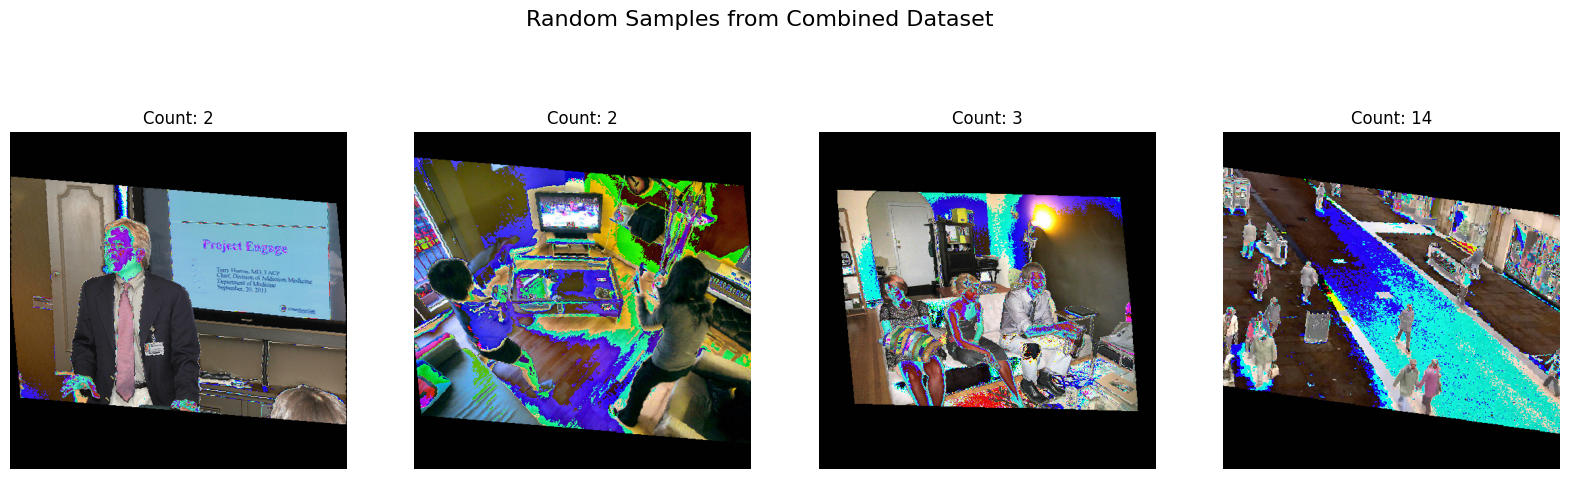

In [19]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import torchvision.transforms as T

def visualize_random_samples(dataset, num_samples=5):
    # Get a list of indices
    indices = random.sample(range(len(dataset)), num_samples)

    # Set up the figure and axes
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 6))
    fig.suptitle('Random Samples from Combined Dataset', fontsize=16)

    for i, idx in enumerate(indices):
        img, count = dataset[idx]

        # Convert tensor to PIL image for visualization
        img = T.ToPILImage()(img)

        # Plot image
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Count: {int(count.item())}')

    plt.show()

# Visualize random samples from the combined training dataset
visualize_random_samples(train_combined_dataset, num_samples=4)

# Optionally visualize random samples from the combined validation dataset
# visualize_random_samples(val_combined_dataset, num_samples=5)


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# import torchvision.transforms as transforms

# # Define the enhanced CNN model
# class EnhancedPeopleCountCNN(nn.Module):
#     def __init__(self):
#         super(EnhancedPeopleCountCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
#         self.bn4 = nn.BatchNorm2d(256)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.dropout = nn.Dropout(0.5)
#         self.fc1 = nn.Linear(256 * 8 * 8, 512)  # Adjust according to the final feature map size
#         self.fc2 = nn.Linear(512, 1)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.pool(self.relu(self.bn1(self.conv1(x))))
#         x = self.pool(self.relu(self.bn2(self.conv2(x))))
#         x = self.pool(self.relu(self.bn3(self.conv3(x))))
#         x = self.pool(self.relu(self.bn4(self.conv4(x))))
#         x = x.view(-1, 256 * 8 * 8)  # Adjust the size based on the final feature map size
#         x = self.dropout(self.relu(self.fc1(x)))
#         x = self.fc2(x)
#         return x.squeeze()

# # Initialize the model, criterion, and optimizer
# model = EnhancedPeopleCountCNN()
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# # Training function
# def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
#     model.train()
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         for i, (images, counts) in enumerate(train_loader):
#             optimizer.zero_grad()
#             outputs = model(images)
#             counts = counts.float()  # Ensure counts are of type float
#             loss = criterion(outputs, counts)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()

#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


# # Train the model
# train_model(model, train_loader, criterion, optimizer, num_epochs=3)

Epoch [1/3], Loss: 1794.3404
Epoch [2/3], Loss: 129.4506
Epoch [3/3], Loss: 51.5045


In [ ]:
# # Evaluation function
# def evaluate_model(model, val_loader):
#     model.eval()
#     with torch.no_grad():
#         total_loss = 0.0
#         for images, counts in val_loader:
#             outputs = model(images)
#             loss = criterion(outputs.squeeze(), counts)
#             total_loss += loss.item()

#     print(f"Validation Loss: {total_loss/len(val_loader):.4f}")

# # Evaluate the model
# evaluate_model(model, val_loader)

Validation Loss: 14.9787


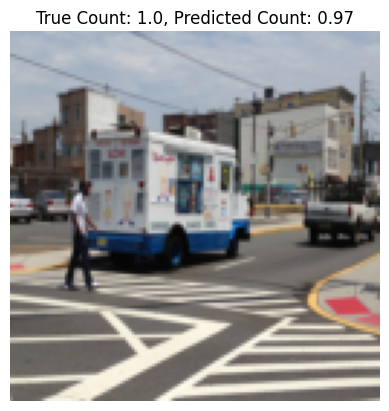

In [ ]:
# import matplotlib.pyplot as plt

# # Function to visualize an image with its predicted count
# def visualize_prediction(model, dataset, index=0):
#     model.eval()  # Set the model to evaluation mode

#     # Get the image and ground truth count from the dataset
#     image, true_count = dataset[index]

#     # Add a batch dimension and pass the image through the model to get the prediction
#     with torch.no_grad():
#         image_tensor = image.unsqueeze(0)  # Add batch dimension
#         predicted_count = model(image_tensor).item()

#     # Convert the image tensor to a numpy array and transpose it to (H, W, C) format
#     image_np = image.numpy().transpose(1, 2, 0)

#     # Plot the image
#     plt.imshow(image_np)
#     plt.title(f"True Count: {true_count}, Predicted Count: {predicted_count:.2f}")
#     plt.axis('off')
#     plt.show()

# # Visualize the prediction for the first image in the validation set
# visualize_prediction(model, val_dataset, index=0)
